# **Drug Trafficking (2008 - 2011) Study Case**
<img src="./images/sof_insignia.png" width="350px">

In [52]:
import pandas as pd 
import numpy as np 
import json
import pymysql 
import sqlite3 
import os 
import boto3 
import warnings 
from sqlalchemy import create_engine
import gc 
from pymysql.err import MySQLError

import seaborn as sns 
import matplotlib.pyplot as plt 

from typing import List, Dict 

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# **Helper Function**
## **To MySQL** 

In [3]:
def to_mysql(backend_engine: 'PyMsql', dir_path: str ):
    """
    Description
    -----------
        - Helper function to convert the CDE dataset into MySQL DB for further query

    Parameter
    ---------
        - backend_engine: a valid SQLAlchemy backend engine 
        - dir_path: a valid CDE path 

    Return
    ------
        - None 
    """

    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"[ ERROR ] Unable to find the following CDE dataset path {dir_path}")

    try:
        
        for csv_file in os.listdir(dir_path):
            if "csv" in csv_file:
                tbl_name: str = csv_file.replace(".csv", "").strip()
                pd.read_csv(os.path.join(dir_path, csv_file) ).to_sql(tbl_name, con=backend_engine, if_exists='append' )

    except ConnectionError as e: 
        
        raise ConnectionError("[ ERROR ] The program has encountered the following error message. Please check your SQL connection !!!.") from e 

## **Get Weapons** 
- Weapons used during the incidents/arrests

In [4]:
def get_weapons(con: 'MySQL' = None) : 

    try: 
        weapon_query: str = """
        
        /*
        ===============================================================
        - Description: Weapon used dur
        
        ================================================================
        */ 
        
        SELECT 
            
            DISTINCT 
            no.offense_id,
            IFNULL(nlt.location_name, "Unknown") AS `location_name`,
            IFNULL(nwt.weapon_name, "Unknown") AS `weapon_type`
            
        FROM nibrs_offense no 
        JOIN nibrs_location_type nlt ON nlt.location_id = no.location_id 
        JOIN nibrs_weapon nw ON nw.offense_id = no.offense_id 
        JOIN nibrs_weapon_type nwt ON nwt.weapon_id = nw.weapon_id 
        LIMIT 5 
        
        """
        
        weap_df: 'DataFrame' = pd.read_sql(weapon_query, con=con)
        weap_df = weap_df.drop_duplicates() 
        return weap_df 
        
    except MySQLError as e: 
        raise MySQLError(f"[ ERROR ] Please check your query !!!") from e 

## **Get Drugs Related Charges** 

In [3]:
def get_drug_related_charges(con: 'MySQL' = None):
    try:
        query: str = """
        
        /* 
        ===================================================================================
            Description: Drug Related Charges in AZ in 2008 - 2011
        ===================================================================================
        */
        SELECT 
            DISTINCT 
            /*Suspect Desc*/
            no.offense_id, 
            nar.arrest_num, 
            nar.arrest_date, 
            nar.age_num,
            IFNULL(nat.arrest_type_name, "Unknown") AS `arrest_type_name`, 
            IFNULL(noft.offense_name, "Unknown") AS `offense_name`, 
            IFNULL(noft.offense_category_name, "Unkown") AS `offense_category_name`, 
            IFNULL(rro.race_desc, "Unknown") AS `suspect_race_desc`, 
            IFNULL(rro.notes, "Unknown") AS `suspect_race_notes`,
        
            
            -- drugs possession 
            IFNULL(nsd.est_drug_qty,0) AS `est_drug_qty`, 
            IFNULL(ndmt.drug_measure_name, "N/A") AS `drug_measure_name`,
            IFNULL(nsdt.suspected_drug_name, "Unknown") AS `suspected_drug_name`,
            
            IFNULL(npd.property_value, 0) AS `property_value`, 
            npd.date_recovered
            
        FROM nibrs_offense no
        JOIN nibrs_offense_type noft ON noft.offense_type_id = no.offense_type_id
        JOIN nibrs_arrestee nar ON nar.incident_id = no.incident_id AND nar.offense_type_id = no.offense_type_id
        JOIN nibrs_arrest_type nat ON nat.arrest_type_id = nar.arrest_type_id
        JOIN ref_race rro ON rro.race_id = nar.race_id -- offender/suspect race
        JOIN nibrs_property np ON np.incident_id = no.incident_id
        JOIN nibrs_property_desc npd ON np.property_id = np.property_id 
        JOIN nibrs_suspected_drug nsd ON nsd.property_id = np.property_id
        JOIN nibrs_suspected_drug_type nsdt ON nsdt.suspected_drug_type_id = nsd.suspected_drug_type_id
        JOIN nibrs_drug_measure_type ndmt ON ndmt.drug_measure_type_id = nsd.drug_measure_type_id
        """
        az_drug_crimes: 'DataFrame' = pd.read_sql(query, con=con)
        az_drug_crimes = az_drug_crimes.drop_duplicates() 
    
        return az_drug_crimes

    except MySQLError as e:
        raise MySQLError(f"[ERROR] Unable to execute the following query {query}. Please check your query again !!!") from e


## **MySQL Cursor** 

In [2]:
con: 'MySQL' = pymysql.connect(user="root", passwd="admin123", host="127.0.0.1")
cursor = con.cursor() 

secrets: 'SecretsManager' = boto3.client("secretsmanager")
sql_arg: str = json.loads(secrets.get_secret_value(SecretId="afghan_project").get("SecretString")).get("sql_args")

## **Populate TX DB with Crimes Incidents between `2008 - 2011`**

In [5]:
engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "TX_2008") )
to_mysql(backend_engine=engine, dir_path="/tmp/TX/2008/")

engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "TX_2009") )
to_mysql(backend_engine=engine, dir_path="/tmp/TX/2009/")

engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "TX_2010") )
to_mysql(backend_engine=engine, dir_path="/tmp/TX/2010/")

engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "TX_2011") )
to_mysql(backend_engine=engine, dir_path="/tmp/TX/2011/")

## **Populate Arizona DB with Crimes Incidents between `2008 - 2011`**

In [9]:
engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "AZ_2008") )
to_mysql(backend_engine=engine, dir_path="/tmp/AZ/2008/")

engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "AZ_2009") )
to_mysql(backend_engine=engine, dir_path="/tmp/AZ/2009/")

engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "AZ_2010") )
to_mysql(backend_engine=engine, dir_path="/tmp/AZ/2010/")

engine: 'pymysql' = create_engine("%s%s" % (sql_arg, "AZ_2011") )
to_mysql(backend_engine=engine, dir_path="/tmp/AZ/2011/")

## **Index Table for All the Crimes in Az and Tx between `2008 - 2011`**
<img src="images/heroin_routes.png" width="1100px">

## **Drufg Trafficking Cases in Arizona** 

In [5]:
crimes_az_tbls: List[str] = pd.read_sql("SHOW DATABASES", con=con)['Database'].apply(lambda row: row if 'AZ' in row else np.nan ).dropna().tolist() 
cde_events: Dict = { db: pymysql.connect(user='root', password=sql_arg.split("/")[2].split(":")[1].split("@")[0], db= f'AZ_200{year}' if year < 10 else f'AZ_20{year}', host='127.0.0.1') for year,db in enumerate(crimes_az_tbls,8) } 
az2008 = cde_events.get("AZ_2008")
az2009 = cde_events.get("AZ_2009")
az2010 = cde_events.get("AZ_2010")
az2011 = cde_events.get("AZ_2011")

In [6]:
drug_charges2008: 'DataFrame'  = get_drug_related_charges(con=az2008)
drug_charges2009: 'DataFrame'  = get_drug_related_charges(con=az2009)
drug_charges2010: 'DataFrame'  = get_drug_related_charges(con=az2010)
drug_charges2011: 'DataFrame'  = get_drug_related_charges(con=az2011)

# @route: SW border 

drug_charges2008['arrest_date'] = pd.to_datetime( drug_charges2008['arrest_date'] )
drug_charges2008['year'] = drug_charges2008['arrest_date'].apply(lambda row: row.year) 

drug_charges2009['arrest_date'] = pd.to_datetime( drug_charges2009['arrest_date'] )
drug_charges2009['year'] = drug_charges2009['arrest_date'].apply(lambda row: row.year) 

## **Drug Charges in AZ Based on Race**

In [17]:
drug_charges2008.head()

,offense_id,arrest_num,arrest_date,age_num,arrest_type_name,offense_name,offense_category_name,suspect_race_desc,suspect_race_notes,est_drug_qty,drug_measure_name,suspected_drug_name,property_value,date_recovered
0,49922333,081119006,2008-11-19,17,Summoned / Cited,Drug/Narcotic Violations,Drug/Narcotic Offenses,White,Unknown,2.052,Gram,Marijuana,1000.0,NaN
1,49910284,080305018,2008-03-05,23,Taken INTO Custody,Drug/Narcotic Violations,Drug/Narcotic Offenses,White,Unknown,1.052,Gram,Marijuana,1000.0,NaN
2,49888613,08000020990,2008-11-21,16,Summoned / Cited,Drug/Narcotic Violations,Drug/Narcotic Offenses,White,Unknown,1.000,Dosage Unit,Marijuana,1000.0,NaN
3,49898049,08000021868,2008-12-05,45,On View,Drug/Narcotic Violations,Drug/Narcotic Offenses,Black or African American,Unknown,1.000,Gram,Cocaine,1000.0,NaN
4,49896721,080311008,2008-03-11,22,On View,False Pretenses/Swindle/Confidence Game,Fraud Offenses,White,Unknown,2.088,Gram,Marijuana,1000.0,NaN


In [73]:
dc_2008 : Dict = drug_charges2008.query("offense_category_name == 'Drug/Narcotic Offenses' ")['suspected_drug_name'].value_counts().to_dict()
dc_2009 : Dict = drug_charges2009.query("offense_category_name == 'Drug/Narcotic Offenses' ")['suspected_drug_name'].value_counts().to_dict()
combined_cases: Dict =  { key: dc_2008.get(key, 0) + dc_2009.get(key, 0 )  for key in set(list(dc_2008.keys())  +  list(dc_2009.keys())) }
combined_cases = dict(sorted(combined_cases.items(), key=lambda item: item[1] ))

## **Drugs Found/Recovered During Arrests in AZ (2008 - 2009)**

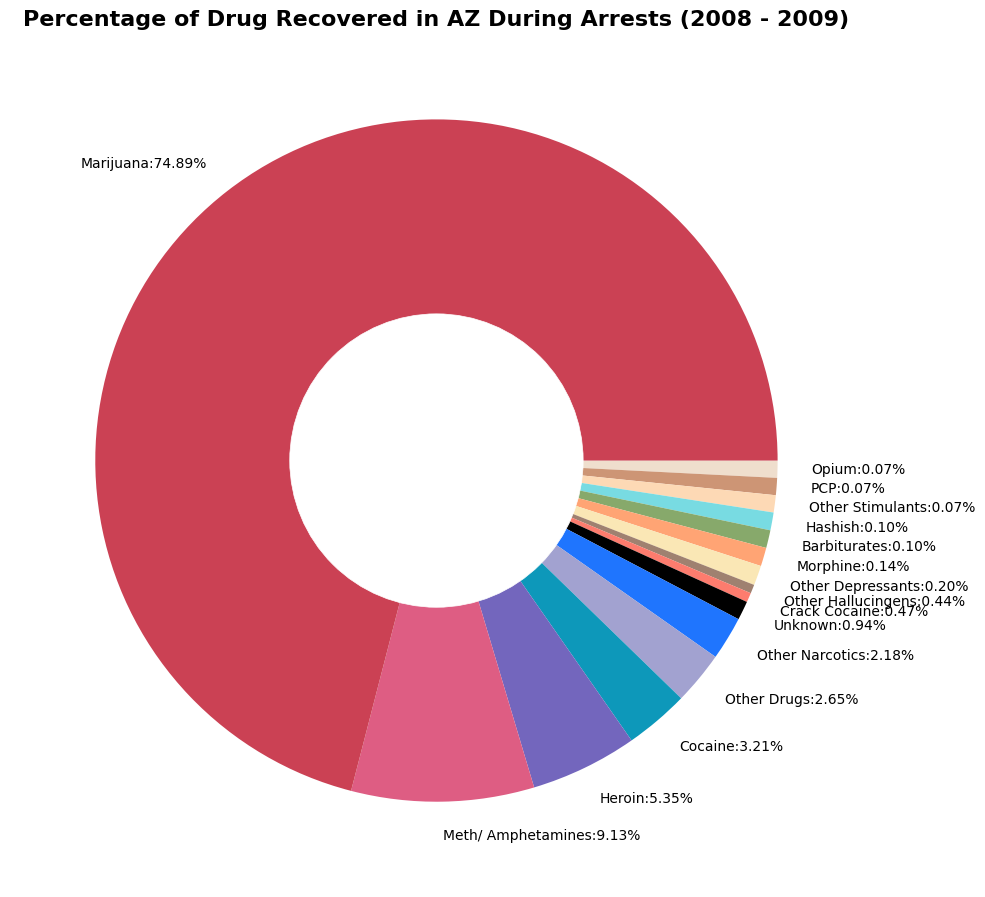

In [106]:
fig = plt.figure(figsize=(10,13))
ax = fig.add_subplot() 
ax.pie(x=[ val if val > 1e4 else val + 3.2e4 for val in combined_cases.values() ], 
       labels=[ f"{k}:{(v/sum(combined_cases.values())) * 100 :.2f}%" for k,v in combined_cases.items() ], colors=sns.crayon_palette(colors=list(sns.crayons.keys())) ) # rotatelabels=True)
ax.invert_yaxis()
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), color='white', radius=0.43))
ax.set_title("Percentage of Drug Recovered in AZ During Arrests (2008 - 2009)", fontweight='bold', fontsize=16)
plt.tight_layout() 

## **Drug/Narcotic Offenses and Race in 2008**

In [107]:
drug_charges2008.query("offense_category_name == 'Drug/Narcotic Offenses' ").groupby(['suspected_drug_name', 'suspect_race_desc']).size().unstack("suspect_race_desc").replace({np.nan: 0.0 }).astype(int)

suspect_race_desc,American Indian or Alaska Native,"Asian, Native Hawaiian, or Other Pacific Islander",Black or African American,Unknown,White
suspected_drug_name,,,,,
Barbiturates,0,0,0,0,1426
Cocaine,0,0,1426,2852,19964
Crack Cocaine,0,0,0,0,2852
Hashish,0,0,0,0,1426
Heroin,0,0,0,0,24242
Marijuana,5704,5704,35650,2852,467728
Meth/ Amphetamines,1426,0,1426,0,106950
Morphine,0,0,0,0,2852
Other Drugs,0,0,0,0,9982


## **Weapons Used/Recovered During The Incident**

In [11]:
# separate query, join pd
get_weapons(con=az2009)

,offense_id,location_name,weapon_type
0,49908694,Residence/Home,Personal Weapons
1,49890513,Residence/Home,Personal Weapons
2,49906147,Parking Lot/Garage,Unknown
3,49906148,Parking Lot/Garage,Personal Weapons
4,49904530,Parking Lot/Garage,Personal Weapons


## **Merged Drug Crime Cases with Weapons Used**

## **Drufg Trafficking Cases in Texas** 

# **References** 
1. https://www.justice.gov/archive/ndic/pubs44/44849/44849p.pdf